## **Data and code setup**

In [1]:
%%capture
!pip install gdown
!pip3 install gpustat

In [2]:
rm -r ./ENet-implementation

rm: cannot remove './ENet-implementation': No such file or directory


In [3]:
%%capture
!git clone https://github.com/Brakahaugen/ENet-implementation.git

In [4]:
%%capture
!gdown https://drive.google.com/uc?id=1gt0nCGft0winZqHBYaTb1EL6zM8lrKPA
!unzip -o camvid.zip

## **Notebook Setup**

In [5]:
# update to tf 2.0
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.1
except Exception:
  pass

# importing standard libraries
import tensorflow as tf
print(tf.__version__)
import matplotlib.pylab as plt
import numpy as np
import os, os.path
from functools import partial
from google.colab import files

# Importing utils and models
import sys
sys.path.append('./ENet-implementation')
from utils import preprocess_img_label, map_singlehead, map_doublehead, map_label, tf_dataset_generator, get_class_weights
from models import EnetModel, TrippleEnetModel

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.4.1


## **Create training test and validation dataset, and get class weights**

In [6]:

def map_doublehead2(img_file, label_file, h_enc, w_enc, h_dec, w_dec):
    '''
    Takes the string tensor pair (img_file, label_file)
    and outputs the (img,label) tf tensor pair

    Arguments
    ----------
    'img_file' = string tensor with img filename
    'label_file' = string tensor with label filename
    'h_enc' = Integer: output tensor height at encoder head
    'w_enc' = Integer: output tensor width at encoder head
    'h_dec' = Integer: output tensor height at decoder head
    'w_dec' = Integer: output tensor width at decoder head

    Returns
    -------
    '(img,(iml_enc,iml_dec))' = image and label tensors
    '''


    #Assume input is 4x larger than the label.

    # decoding image
    img = tf.io.read_file(img_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [h_dec*2, w_dec*2])

    # decoding label
    iml = tf.io.read_file(label_file)
    iml = tf.image.decode_png(iml, channels=1)
    iml = tf.image.convert_image_dtype(iml, tf.uint8)
    iml_enc = tf.image.resize(iml, [h_enc, w_enc], method='nearest')
    iml_dec = tf.image.resize(iml, [h_dec, w_dec], method='nearest')
    return (img, (iml_enc, iml_dec))

In [7]:
# creating datasets
img_pattern = "./ENet-implementation/data/images/*.png"
label_pattern = "./ENet-implementation/data/labels/*.png"
img_pattern_val = "./dataset/val/images/*.png"
label_pattern_val = "./dataset/val/labels/*.png"
img_pattern_test = "./dataset/test/images/*.png"
label_pattern_test = "./dataset/test/labels/*.png"

# batch size
batch_size = 1

# image size
img_height = 360
img_width = 480
h_enc = img_height // 8
w_enc = img_width // 8
h_dec = img_height
w_dec = img_width

# create (img,label) string tensor lists
filelist_train = preprocess_img_label(img_pattern, label_pattern)
filelist_val = preprocess_img_label(img_pattern_val, label_pattern_val)
filelist_test = preprocess_img_label(img_pattern_test, label_pattern_test)

# training dataset size
n_train = tf.data.experimental.cardinality(filelist_train).numpy()
n_val = tf.data.experimental.cardinality(filelist_val).numpy()
n_test = tf.data.experimental.cardinality(filelist_test).numpy()

# define mapping functions for single and double head nets
map_single = lambda img_file, label_file: map_singlehead(
    img_file, label_file, h_dec, w_dec)
map_double = lambda img_file, label_file: map_doublehead(
    img_file, label_file, h_enc, w_enc, h_dec, w_dec)

# create single head datasets
train_single_ds = filelist_train.shuffle(n_train).map(map_single).cache().batch(batch_size).repeat()
val_single_ds = filelist_val.map(map_single).cache().batch(batch_size).repeat()
test_single_ds = filelist_test.map(map_single).cache().batch(batch_size).repeat()

# create double head datasets
train_double_ds = filelist_train.shuffle(n_train).map(map_double).cache().batch(batch_size).repeat()
val_double_ds = filelist_val.map(map_double).cache().batch(batch_size).repeat()
test_double_ds = filelist_test.map(map_double).cache().batch(batch_size).repeat()

# get class weights
label_filelist = tf.data.Dataset.list_files(label_pattern, shuffle=False)
label_ds = label_filelist.map(lambda x: map_label(x, h_dec, w_dec))
class_weights = get_class_weights(label_ds).tolist()
class_weights = {i: class_weights[i ] for i in range(0, len(class_weights))} 

## **Example (Image,Label) pair from the training set**

(1, 720, 960, 3)
(1, 45, 60, 1)
(1, 360, 480, 1)


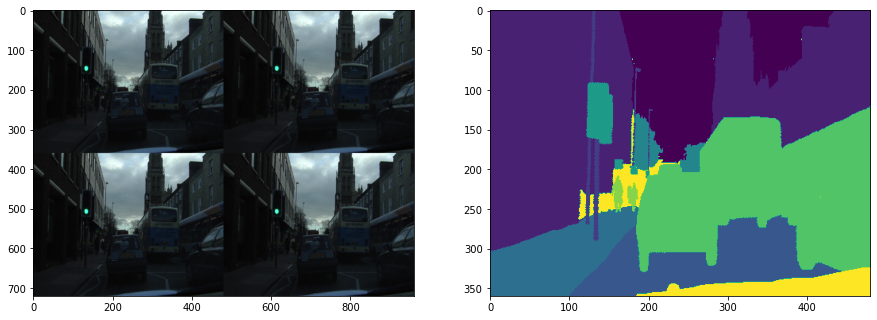

In [8]:
for img,iml in train_double_ds.take(1):
  print(img.shape)
  print(iml[0].shape)
  print(iml[1].shape)
  plt.figure(figsize=(15,10))
  plt.subplot(1,2,1)
  plt.imshow(img.numpy()[0,:,:,:])
  plt.subplot(1,2,2)
  plt.imshow(iml[1].numpy()[0,:,:,0])

## Losses and Metrics

In [9]:
accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
loss_1 = tf.keras.losses.SparseCategoricalCrossentropy(name='loss_1')
loss_2 = tf.keras.losses.SparseCategoricalCrossentropy(name='loss_2')

## **1 - Two stage training: first Encoder then Decoder**

### Training the encoder

In [10]:
Enet = EnetModel(C=12,MultiObjective=True,l2=1e-3)

True


In [11]:
for layer in Enet.layers[-6:]:
  layer.trainable = False

In [12]:
# compile model: only the first objective matters
n_epochs = 60
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
Enet.compile(optimizer=adam_optimizer,
             loss=[loss_1,loss_2],
             metrics=accuracy,
             loss_weights=[1.0,0.0])

In [13]:
enet_enc_history = Enet.fit(x= train_double_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_double_ds,
        validation_steps=n_val//batch_size//5)

Epoch 1/60
(None, 720, 960, 12)


KeyboardInterrupt: ignored

### Training the decoder

In [ ]:
for layer in Enet.layers[-6:]:
  layer.trainable = True
for layer in Enet.layers[:-6]:
  layer.trainable = False

In [ ]:
# compile model: only the first objective matters
n_epochs = 60
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
Enet.compile(optimizer=adam_optimizer,
             loss=[loss_1,loss_2],
             metrics=accuracy,
             loss_weights=[0.0,1.0])

In [ ]:
enet_dec_history = Enet.fit(x= train_double_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_double_ds,
        validation_steps=n_val//batch_size//5)

### Check performance

In [ ]:
Enet.evaluate(x=test_double_ds,steps=n_test//batch_size)

In [ ]:
loss = enet_dec_history.history['loss']
val_loss = enet_dec_history.history['val_loss']
acc = enet_dec_history.history['output_2_accuracy']
val_acc = enet_dec_history.history['val_output_2_accuracy']

epochs = range(n_epochs)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss/np.max(loss), 'r', label='Training loss')
plt.plot(epochs, val_loss/np.max(val_loss), 'b', label='Validation loss')
plt.plot(epochs, acc, 'r:', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## **2 - Training both objectives simultaneously**

###Training

In [14]:
EnetMulti = TrippleEnetModel(C=12,MultiObjective=True,l2=1e-3)

True
True
True


In [15]:
# compile model: only the first objective matters
n_epochs = 80
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
EnetMulti.compile(optimizer=adam_optimizer,
             loss=[loss_1,loss_2],
             metrics=accuracy,
             loss_weights=[0.5,0.5])

In [ ]:
enet_multi_history = EnetMulti.fit(x= train_double_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_double_ds,
        validation_steps=n_val//batch_size//5)

Epoch 1/80
(None, 360, 480, 12)
(None, 360, 480, 12)
(None, 360, 480, 12)
(None, 360, 480, 12)
(None, 360, 480, 12)
(None, 360, 480, 12)
1/1 [==============================] - ETA: 0s - loss: 5.9927 - output_1_loss: 2.8738 - output_2_loss: 2.5120 - output_1_accuracy: 0.0381 - output_2_accuracy: 0.0582(None, 360, 480, 12)
(None, 360, 480, 12)
(None, 360, 480, 12)
1/1 [==============================] - 65s 65s/step - loss: 5.9927 - output_1_loss: 2.8738 - output_2_loss: 2.5120 - output_1_accuracy: 0.0381 - output_2_accuracy: 0.0582 - val_loss: 5.7793 - val_output_1_loss: 2.4900 - val_output_2_loss: 2.4849 - val_output_1_accuracy: 0.0772 - val_output_2_accuracy: 0.0816
Epoch 2/80
1/1 [==============================] - 1s 1s/step - loss: 5.9280 - output_1_loss: 2.7636 - output_2_loss: 2.5089 - output_1_accuracy: 0.0641 - output_2_accuracy: 0.0669 - val_loss: 5.7690 - val_output_1_loss: 2.4856 - val_output_2_loss: 2.4847 - val_output_1_accuracy: 0.0369 - val_output_2_accuracy: 0.0826
Epoch 

### Check performance

In [ ]:
EnetMulti.evaluate(x=test_double_ds,steps=n_test//batch_size)

In [ ]:
loss = enet_multi_history.history['loss']
val_loss = enet_multi_history.history['val_loss']
acc = enet_multi_history.history['output_2_accuracy']
val_acc = enet_multi_history.history['val_output_2_accuracy']

epochs = range(n_epochs)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss/np.max(loss), 'r', label='Training loss')
plt.plot(epochs, val_loss/np.max(val_loss), 'b', label='Validation loss')
plt.plot(epochs, acc, 'r:', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## **3 - EndtoEnd Training**

In [ ]:
EnetEndToEnd = EnetModel(C=12,MultiObjective=False,l2=1e-3)

In [ ]:
# compile model: only the first objective matters
n_epochs = 80
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
EnetEndToEnd.compile(optimizer=adam_optimizer,
             loss=loss_1,
             metrics=accuracy)

In [ ]:
enet_endtoend_history = EnetEndToEnd.fit(x= train_single_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_single_ds,
        validation_steps=n_val//batch_size//5)

### Check performance

In [ ]:
EnetEndToEnd.evaluate(x=test_single_ds,steps=n_test//batch_size)

In [ ]:
loss = enet_endtoend_history.history['loss']
val_loss = enet_endtoend_history.history['val_loss']
acc = enet_endtoend_history.history['accuracy']
val_acc = enet_endtoend_history.history['val_accuracy']

epochs = range(n_epochs)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss/np.max(loss), 'r', label='Training loss')
plt.plot(epochs, val_loss/np.max(val_loss), 'b', label='Validation loss')
plt.plot(epochs, acc, 'r:', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## **Test Masks**

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
for img,iml in train_dec_ds.take(10):
  img_test = img
  iml_test = iml

img_enc_probs, img_dec_probs = Enet(img_test[0:1,:,:,:])
img_enc_probs, img_multi_probs = EnetMulti(img_test[0:1,:,:,:])
img_endtoend_probs = EnetEndToEnd(img_test[0:1,:,:,:])
img_dec_out = create_mask(img_dec_probs)
img_multi_out = create_mask(img_multi_probs)
img_endtoend_out = create_mask(img_endtoend_probs)

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.xticks([])
plt.yticks([])
plt.title('Image',fontdict={'fontsize':20})
plt.imshow(img_test.numpy()[0,:,:,:])

plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.title('Ground Truth',fontdict={'fontsize':20})
plt.imshow(iml_test.numpy()[0,:,:,0])

plt.subplot(2,3,4)
plt.imshow(img_dec_out[:,:,0])
plt.xticks([])
plt.yticks([])
plt.title('Encoder + Decoder',fontdict={'fontsize':20})

plt.subplot(2,3,5)
plt.xticks([])
plt.yticks([])
plt.title('Multiple Objectives',fontdict={'fontsize':20})
plt.imshow(img_multi_out[:,:,0])

plt.subplot(2,3,6)
plt.xticks([])
plt.yticks([])
plt.title('End to End',fontdict={'fontsize':20})
plt.imshow(img_endtoend_out[:,:,0])

plt.tight_layout()
plt.savefig('./segmentation.png')

# **Save models**
You can download them in your google drive. Mount it with che command below and drag and drop the weight files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
Enet.save_weights('Enet.tf')
EnetMulti.save_weights('EnetMulti.tf')
EnetEndToEnd.save_weights('EnetEndToEnd.tf')